In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# define transformations
data_transform_tr = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    #transforms.ColorJitter(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),    # mean val for each rgb channel, corresponding std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))
])

# define transformations
data_transform_te = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),    # mean val for each rgb channel, corresponding std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


training_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=data_transform_tr
)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=data_transform_te
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

# Get cpu, gpu or mps device for training.

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


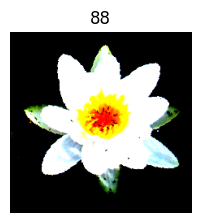

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


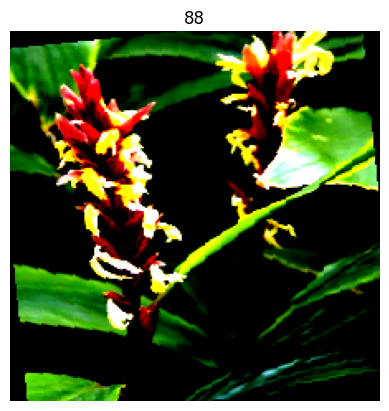

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


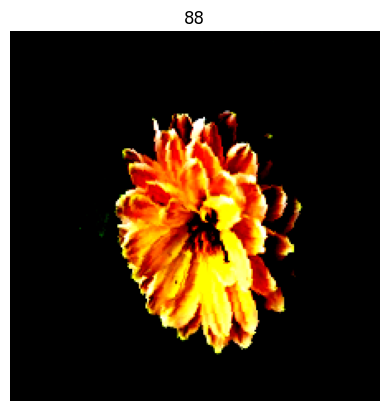

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


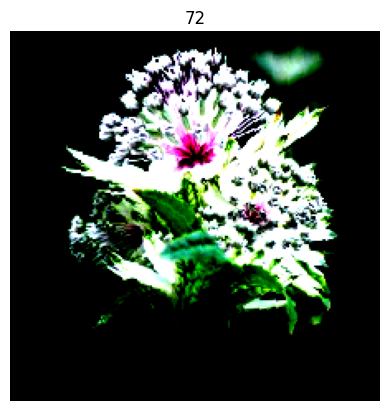

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


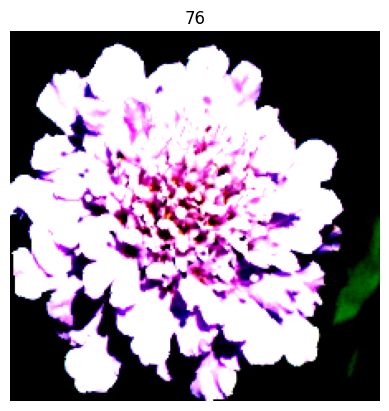

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


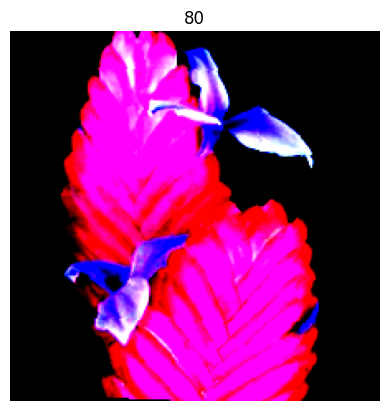

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


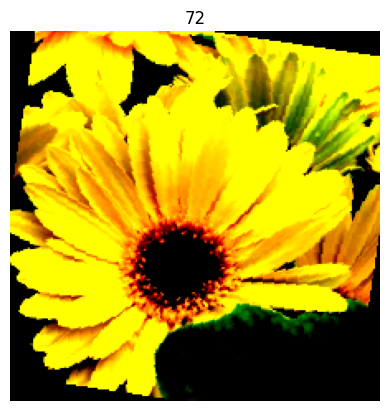

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


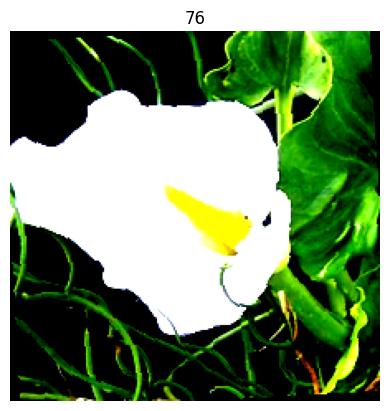

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


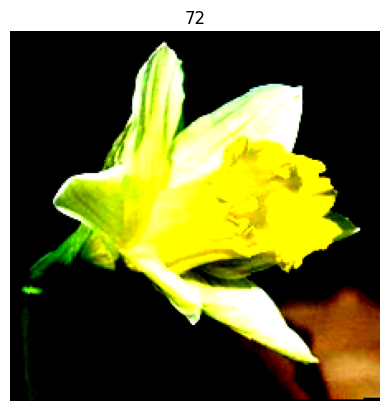

In [96]:
import scipy.io

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# load labels from .mat file
labels_mat = scipy.io.loadmat("imagelabels.mat")
labels = labels_mat['labels'][0]

#display data

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    # display img
    plt.imshow(img.permute(1,2,0))
    # get the class name using the label
    class_index = labels[sample_idx] - 1
    plt.title(class_index)
    plt.show()

In [97]:
print(len(labels))
labels

8189


array([77, 77, 77, ..., 62, 62, 62], dtype=uint8)

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 2, 1)
        self.conv2 = nn.Conv2d(6, 16, 2, 1, padding=4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(55696, 600)
        self.fc2 = nn.Linear(600, 512)
        #self.dropout = nn.Dropout(p = 0.5)
        self.bn = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 102)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.bn(x)
        x = self.fc4(x)
        return self.logsoftmax(x)

model = NeuralNetwork()

learning_rate = 1e-3
batch_size = 64
epochs = 5

In [4]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
#loss_fn = FocalLoss(gamma=2, alpha=None, reduction='mean')

In [5]:
#from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

NameError: name 'StepLR' is not defined

In [101]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    #return test_loss

In [ ]:
loss_fn = nn.CrossEntropyLoss()
#loss_fn = FocalLoss(gamma=2, alpha=None, reduction='mean')

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    scheduler.step()
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 4.848965  [   64/ 1020]
loss: 4.668475  [  128/ 1020]
loss: 4.571118  [  192/ 1020]
loss: 4.610629  [  256/ 1020]
loss: 4.508801  [  320/ 1020]
loss: 4.429401  [  384/ 1020]
loss: 4.369603  [  448/ 1020]
loss: 4.365665  [  512/ 1020]
loss: 4.394060  [  576/ 1020]
loss: 4.371408  [  640/ 1020]
loss: 4.291635  [  704/ 1020]
loss: 4.323919  [  768/ 1020]
loss: 4.347120  [  832/ 1020]
loss: 4.251674  [  896/ 1020]
loss: 4.243787  [  960/ 1020]
loss: 4.281856  [ 1020/ 1020]
Test Error: 
 Accuracy: 1.4%, Avg loss: 4.939114 

Epoch 2
-------------------------------
loss: 4.152288  [   64/ 1020]
loss: 4.127630  [  128/ 1020]
loss: 4.198867  [  192/ 1020]
loss: 4.069003  [  256/ 1020]
loss: 4.067204  [  320/ 1020]
loss: 3.995375  [  384/ 1020]
loss: 4.075801  [  448/ 1020]
loss: 4.113054  [  512/ 1020]
loss: 4.147231  [  576/ 1020]
loss: 4.102679  [  640/ 1020]
loss: 4.148338  [  704/ 1020]
loss: 3.946280  [  768/ 1020]
loss: 4.074975  [  832/ 1020]